In [15]:
##------- 1. Load libraries & model
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data
df = pd.read_csv("NikeProductDescriptions.csv")
#show basic information like the nb of nulls an type of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None


In [3]:
#filter subtitles keep only the target subtitles
target_subtitles = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
df_filtered = df[df['Subtitle'].isin(target_subtitles) | df['Subtitle'].str.contains("Shorts", case=False)].copy()

In [4]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [5]:
# Convert column to list of strings
descriptions = df_filtered['Product Description'].tolist()

In [6]:
##------- 2. Encode a Sentence and View Token Embeddings
# Tokenize input
inputs = tokenizer(descriptions, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    # Get the last hidden state
    last_hidden_states = outputs.last_hidden_state
print("Token embeddings shape:", last_hidden_states.shape) # (1, seq_len, hidden_size)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

Token embeddings shape: torch.Size([155, 133, 768])


In [7]:
for token, vec in zip(tokens, last_hidden_states[0]):
    print(f"{token}: {vec[:5].tolist()}...")

[CLS]: [-0.08839482069015503, -0.21747583150863647, 0.2291990965604782, -0.34087294340133667, -0.8684621453285217]...
it: [-0.027697354555130005, -0.14245405793190002, -0.2904760241508484, 0.16466960310935974, 0.7746036648750305]...
doesn: [0.7258886098861694, -0.07981712371110916, 0.9665309190750122, -0.07207547873258591, -0.6748963594436646]...
': [0.8017147183418274, 0.18710580468177795, -0.09314596652984619, 0.4025837779045105, -0.27910345792770386]...
t: [0.7048619985580444, -1.0851656198501587, 0.8706303238868713, 0.128591850399971, 0.11973952502012253]...
get: [-0.031509239226579666, -0.603369951248169, 1.058544635772705, 0.49108943343162537, 0.3312031328678131]...
more: [-0.047702472656965256, -0.8108359575271606, -0.054153475910425186, -0.2452329844236374, -0.043833985924720764]...
legendary: [0.7224892973899841, -0.3590068221092224, 0.24219635128974915, -0.24427597224712372, -0.09555574506521225]...
than: [-0.392074316740036, -0.5626129508018494, 0.8153018951416016, 0.4069018

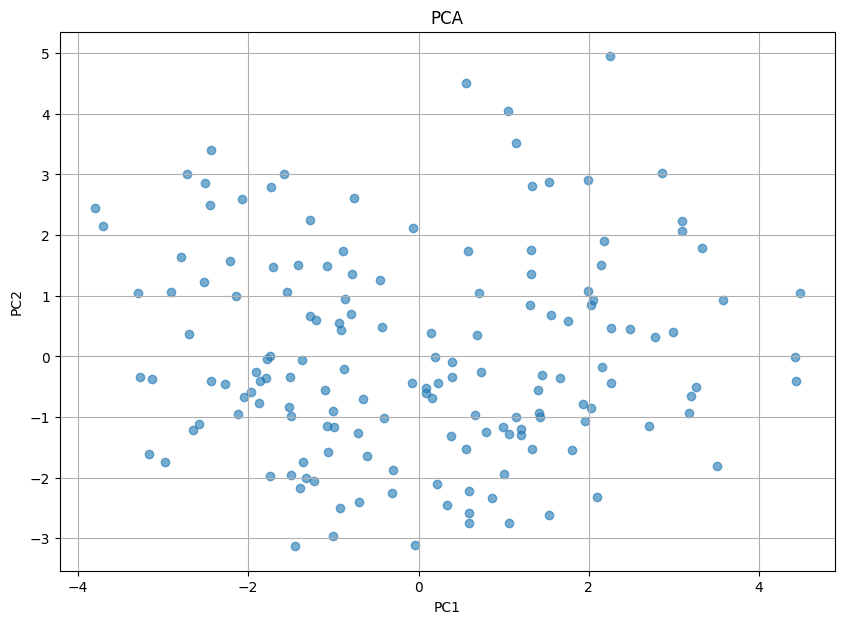

Top contributing original dimensions to PC1: [489 431 227 727 408 283 679 430 742 567]
Top contributing original dimensions to PC2: [752 667 273 550 611 411 308 522 591  48]


In [12]:
cls_embeddings = last_hidden_states[:, 0, :] 

pca = PCA(n_components=2)
reduced_cls = pca.fit_transform(cls_embeddings.numpy()) 

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_cls[:, 0], reduced_cls[:, 1], alpha=0.6)
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

loadings = pca.components_ 
top_pc1_dims = np.argsort(np.abs(loadings[0]))[::-1][:10]
top_pc2_dims = np.argsort(np.abs(loadings[1]))[::-1][:10]
print("top contributing PC1:", top_pc1_dims)
print("top contributing to PC2:", top_pc2_dims)

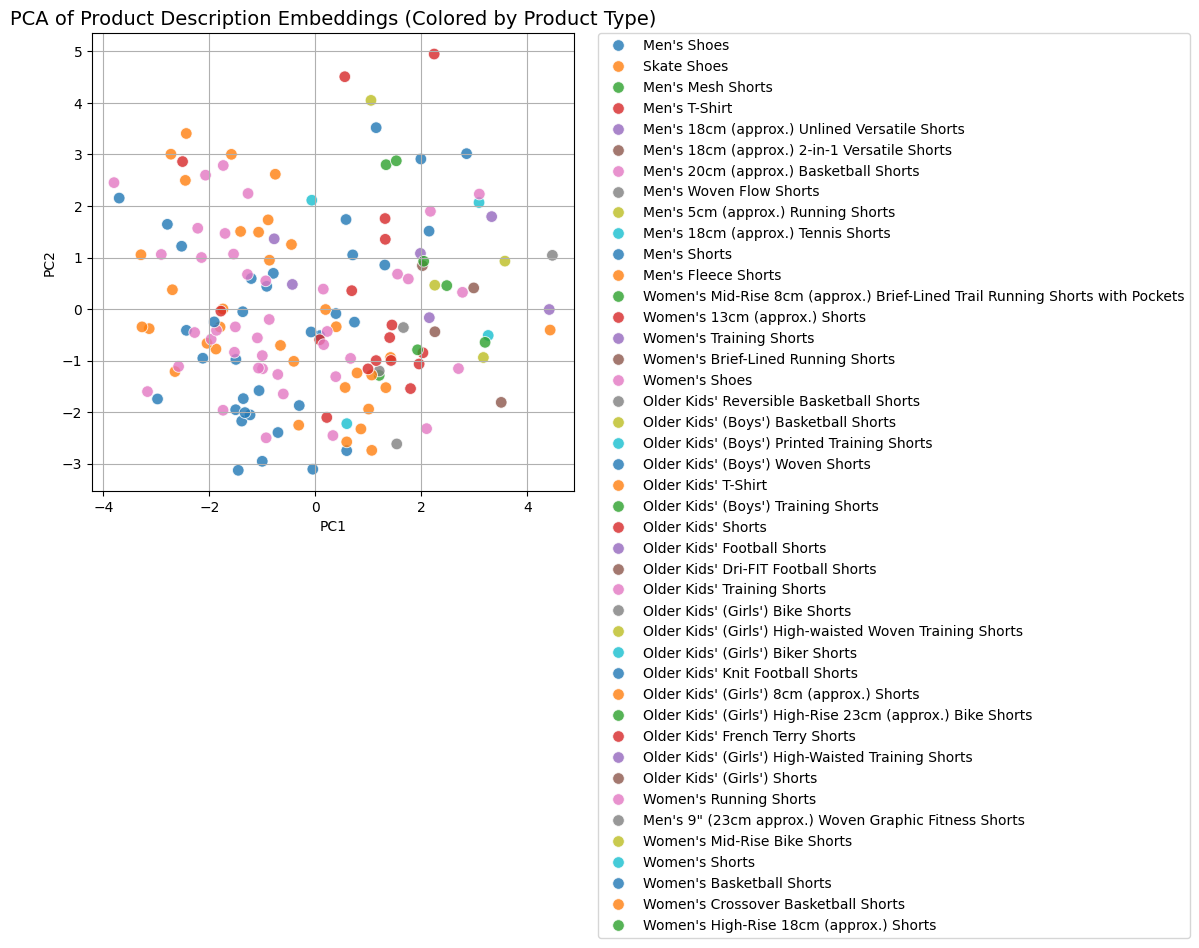

In [16]:
# Plot with labels
labels = df_filtered['Subtitle'].tolist() 
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_cls[:, 0], y=reduced_cls[:, 1], hue=labels, palette='tab10', s=70, alpha=0.8)
plt.title('PCA of Product Description Embeddings (Colored by Product Type)', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.show()